In [1]:
import os

os.chdir("../../../test_data/system_tests/proteoforms/mann_labs_egfr")

In [2]:


RESULTS_DIR = "./results_sample_amounts/"
CONDPAIRS = [("HeLa_EGF_100ng","HeLa_EGF_200ng"), ("HeLa_EGF_200ng","HeLa_EGF_400ng"),
             ("HeLa_unt_100ng","HeLa_unt_200ng"), ("HeLa_unt_200ng","HeLa_unt_400ng")]

CONDPAIR_100_200_EGF = CONDPAIRS[0]
CONDPAIR_200_400_EGF = CONDPAIRS[1]
CONDPAIR_100_200_UNT = CONDPAIRS[2]
CONDPAIR_200_400_UNT = CONDPAIRS[3]



In [3]:
#compare up and downregulated proteins

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_venn as venn
import alphaquant.diffquant_utils as aqutils

condpairtree_egf_100_to_200 = aqutils.read_condpair_tree(cond1=CONDPAIR_100_200_EGF[0], cond2=CONDPAIR_100_200_EGF[1], results_folder=RESULTS_DIR)
condpairtree_egf_200_to_400 = aqutils.read_condpair_tree(cond1=CONDPAIR_200_400_EGF[0], cond2=CONDPAIR_200_400_EGF[1], results_folder=RESULTS_DIR)

condpairtree_unt_100_to_200 = aqutils.read_condpair_tree(cond1=CONDPAIR_100_200_UNT[0], cond2=CONDPAIR_100_200_UNT[1], results_folder=RESULTS_DIR)
condpairtree_unt_200_to_400 = aqutils.read_condpair_tree(cond1=CONDPAIR_200_400_UNT[0], cond2=CONDPAIR_200_400_UNT[1], results_folder=RESULTS_DIR)



In [4]:
display(condpairtree_egf_100_to_200)
display(condpairtree_egf_200_to_400)
display(condpairtree_unt_100_to_200)

display(condpairtree_unt_200_to_400)


AnyNode(name=['HeLa_EGF_100ng', 'HeLa_EGF_200ng'])

AnyNode(name=['HeLa_EGF_200ng', 'HeLa_EGF_400ng'])

AnyNode(name=['HeLa_unt_100ng', 'HeLa_unt_200ng'])

AnyNode(name=['HeLa_unt_200ng', 'HeLa_unt_400ng'])

In [7]:
import anytree
def generate_fold_change_tables_based_on_trees(list_of_condpair_trees, fc_signs_per_tree, node_type_of_interest):
    
    for tree, idx in enumerate(list_of_condpair_trees):
        fc_sign = fc_signs_per_tree[idx]
        level_nodes = anytree.search.findall(tree, filter_=lambda node: node.type == node_type_of_interest)
        

In [8]:
import pandas as pd

def generate_fold_change_tables_based_on_trees(list_of_condpair_trees, fc_signs_per_tree, node_type_of_interest):
    # Dictionaries to store fold change and p-values with node names as keys and another dictionary as values
    fc_values = {}
    p_values = {}

    for idx, tree in enumerate(list_of_condpair_trees):
        condpairname = aqutils.get_condpairname(tree.name)
        fc_sign = fc_signs_per_tree[idx]
        
        # Initialize dictionaries for the current condition pair name
        fc_values[condpairname] = {}
        p_values[condpairname] = {}
        
        # Find all nodes of the given type within the tree
        level_nodes = anytree.search.findall(tree, filter_=lambda node: node.parent is not None and node.type == node_type_of_interest)
        
        for node in level_nodes:
            # Add the fold change value and p-value for the current node
            fc_values[condpairname][node.name] = fc_sign * node.fc
            p_values[condpairname][node.name] = getattr(node, 'p_val', None)  # Assume node has p_val attribute

    # Convert the nested dictionaries to pandas DataFrames
    df_fc = pd.DataFrame.from_dict(fc_values, orient='columns')
    df_p = pd.DataFrame.from_dict(p_values, orient='columns')
    
    # Merge dataframes on index (node name) and add appropriate suffixes
    df_merged = df_fc.merge(df_p, left_index=True, right_index=True, suffixes=('_log2fc', '_p_value'))

    assert_nan_consistency(df_merged)
    
    return df_merged


def assert_nan_consistency(df_merged):
    for col in df_merged.columns:
        if '_p_value' in col:
            fc_col = col.replace('_p_value', '_log2fc')
            assert all(df_merged[df_merged[col].isna()][fc_col].isna()), f"Mismatch detected in columns {col} and {fc_col}"

df_regulation = generate_fold_change_tables_based_on_trees([condpairtree_egf_100_to_200, condpairtree_egf_200_to_400, condpairtree_unt_100_to_200, condpairtree_unt_200_to_400], [1, 1, 1, 1], "mod_seq_charge")


In [9]:
display(df_regulation)

,HeLa_EGF_100ng_VS_HeLa_EGF_200ng_log2fc,HeLa_EGF_200ng_VS_HeLa_EGF_400ng_log2fc,HeLa_unt_100ng_VS_HeLa_unt_200ng_log2fc,HeLa_unt_200ng_VS_HeLa_unt_400ng_log2fc,HeLa_EGF_100ng_VS_HeLa_EGF_200ng_p_value,HeLa_EGF_200ng_VS_HeLa_EGF_400ng_p_value,HeLa_unt_100ng_VS_HeLa_unt_200ng_p_value,HeLa_unt_200ng_VS_HeLa_unt_400ng_p_value
SEQ_ENAEVDGDDDAEEMEAK_MOD__ENAEVDGDDDAEEMEAK__CHARGE_2_,0.065756,-0.268645,-0.574815,-0.324527,0.767561,0.007426,0.057041,0.011545
SEQ_ENAEVDGDDDAEEMEAK_MOD__ENAEVDGDDDAEEM[Oxidation (M)]EAK__CHARGE_2_,-0.320394,0.289043,-0.270131,0.219741,0.024490,0.065036,0.298852,0.427173
SEQ_PGYGAYDAFK_MOD__PGYGAYDAFK__CHARGE_2_,-0.622100,0.137857,-0.182398,0.091354,0.189202,0.432001,0.740743,0.640425
SEQ_ADIEVACYGYEGIDAVK_MOD__ADIEVAC[Carbamidomethyl (C)]YGYEGIDAVK__CHARGE_2_,-0.494582,0.126068,-0.232965,0.169095,0.000292,0.132119,0.066494,0.490542
SEQ_ADIEVACYGYEGIDAVK_MOD__ADIEVAC[Carbamidomethyl (C)]YGYEGIDAVK__CHARGE_3_,-0.028126,0.267371,-0.351134,0.028063,0.927352,0.257846,0.075513,0.928876
...,...,...,...,...,...,...,...,...
SEQ_NDHEIINCSNCESVGTNADTPVLR_MOD__NDHEIINC[Carbamidomethyl (C)]SNC[Carbamidomethyl (C)]ESVGTNADTPVLR__CHARGE_3_,NaN,NaN,NaN,-0.286748,NaN,NaN,NaN,0.623331
SEQ_DFNIPGFPTVR_MOD__DFNIPGFPTVR__CHARGE_2_,NaN,NaN,NaN,-0.704084,NaN,NaN,NaN,0.237752
SEQ_ANIMNEKCVVENAEK_MOD__ANIMNEKC[Carbamidomethyl (C)]VVENAEK__CHARGE_3_,NaN,NaN,NaN,1.971627,NaN,NaN,NaN,0.732717
SEQ_IVEAPSQSESEPEK_MOD__IVEAPSQSESEPEK__CHARGE_2_,NaN,NaN,NaN,-0.670879,NaN,NaN,NaN,0.132152


In [10]:
log2fc_cols = [col for col in df_regulation.columns if 'log2fc' in col]
count_series = df_regulation[log2fc_cols].notna().sum(axis=0)
display(count_series)


HeLa_EGF_100ng_VS_HeLa_EGF_200ng_log2fc     98249
HeLa_EGF_200ng_VS_HeLa_EGF_400ng_log2fc    114889
HeLa_unt_100ng_VS_HeLa_unt_200ng_log2fc     85218
HeLa_unt_200ng_VS_HeLa_unt_400ng_log2fc    109540
dtype: int64

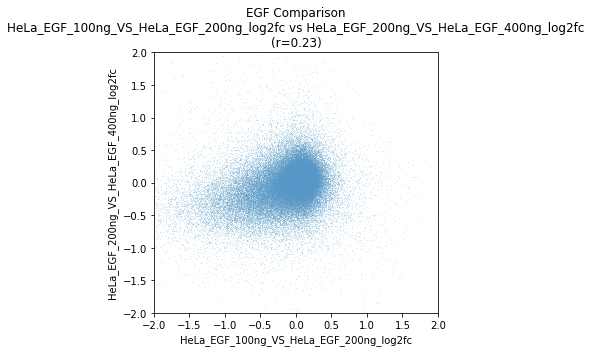

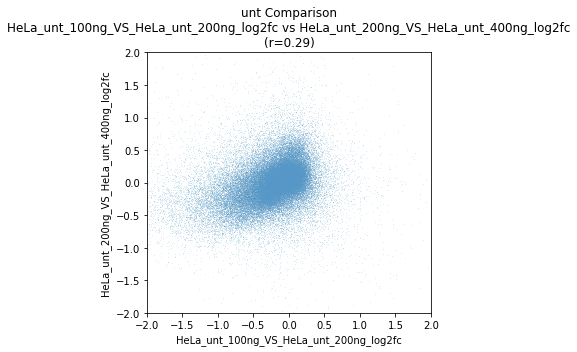

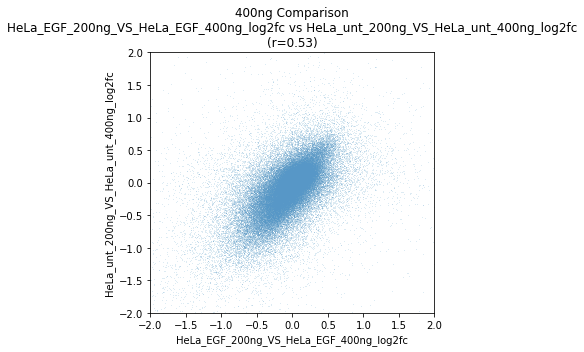

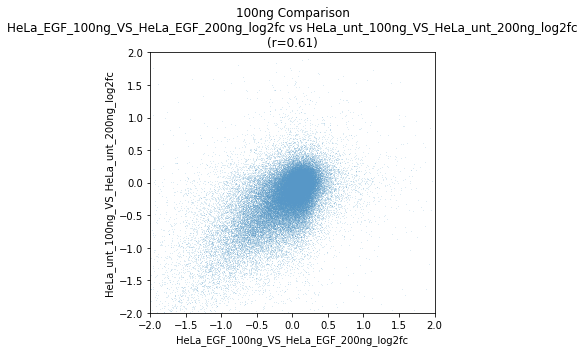

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def scatter_for_condition(df, condition):
    # Get the log2fc columns for the specified condition
    log2fc_cols = [col for col in df.columns if condition in col and "log2fc" in col]
    
    if len(log2fc_cols) != 2:
        raise ValueError("There should be exactly 2 log2fc columns for a given condition.")
    
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Scatter plot
    sns.scatterplot(data=df, x=log2fc_cols[0], y=log2fc_cols[1], ax=ax, s=0.2)
    
    # Calculating correlation
    corr = df[log2fc_cols[0]].corr(df[log2fc_cols[1]])
    
    # Setting title with correlation
    ax.set_title(f'{condition} Comparison\n{log2fc_cols[0]} vs {log2fc_cols[1]}\n(r={corr:.2f})')
    ax.set_xlabel(log2fc_cols[0])
    ax.set_ylabel(log2fc_cols[1])
    
    # Ensure x- and y- limits are the same
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    min_min = min(xlims[0], ylims[0])
    max_max = max(xlims[1], ylims[1])
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    
    plt.tight_layout()
    plt.show()

# Sample usage
# scatter_for_condition(df, 'EGF')
# scatter_for_condition(df, 'unt')

scatter_for_condition(df_regulation, 'EGF')
scatter_for_condition(df_regulation, 'unt')
scatter_for_condition(df_regulation, '400ng')
scatter_for_condition(df_regulation, '100ng')

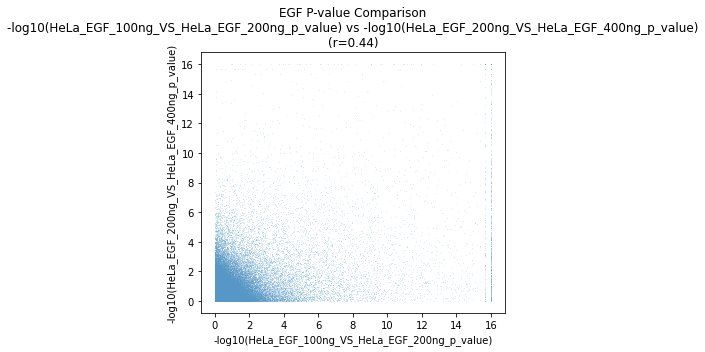

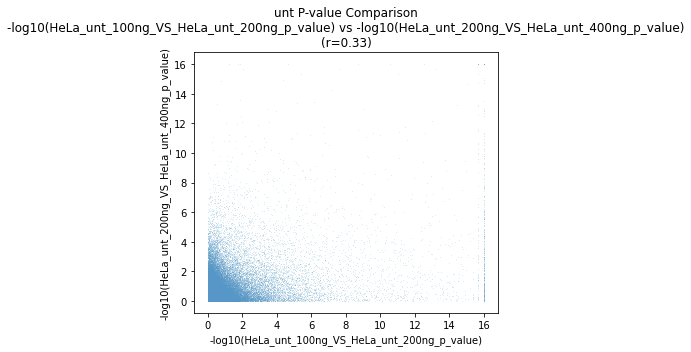

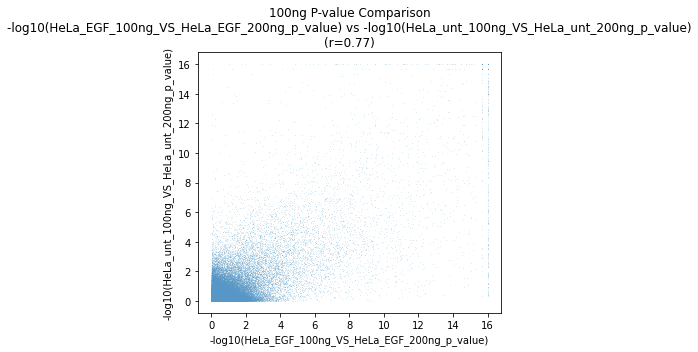

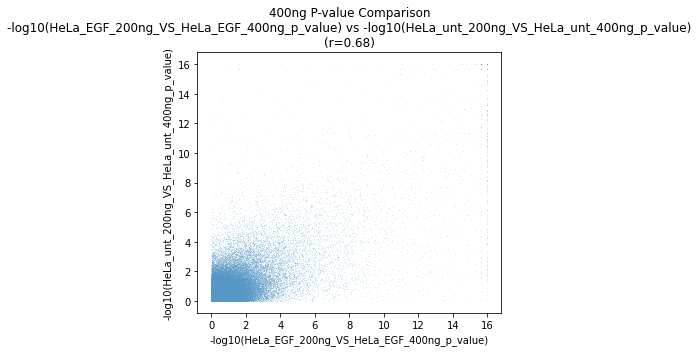

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def scatter_for_pvalue(df, condition):
    # Get the p_value columns for the specified condition
    pvalue_cols = [col for col in df.columns if condition in col and "p_value" in col]
    
    if len(pvalue_cols) != 2:
        raise ValueError("There should be exactly 2 p_value columns for a given condition.")
    
    # Log transform the p-values
    df['log_pvalue_0'] = -np.log10(df[pvalue_cols[0]])
    df['log_pvalue_1'] = -np.log10(df[pvalue_cols[1]])
    
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Scatter plot
    sns.scatterplot(data=df, x='log_pvalue_0', y='log_pvalue_1', ax=ax, s=0.2)
    
    # Calculating correlation
    corr = df['log_pvalue_0'].corr(df['log_pvalue_1'])
    
    # Setting title with correlation
    ax.set_title(f'{condition} P-value Comparison\n-log10({pvalue_cols[0]}) vs -log10({pvalue_cols[1]})\n(r={corr:.2f})')
    ax.set_xlabel(f'-log10({pvalue_cols[0]})')
    ax.set_ylabel(f'-log10({pvalue_cols[1]})')
    
    # If you want to set the axis limits, you can do so
    # ax.set_xlim(-2, 2)
    # ax.set_ylim(-2, 2)
    
    plt.tight_layout()
    plt.show()

# Example call:
# scatter_for_pvalue(df, "HeLa_EGF")
scatter_for_pvalue(df_regulation, "EGF")
scatter_for_pvalue(df_regulation, "unt")
scatter_for_pvalue(df_regulation, "100ng")
scatter_for_pvalue(df_regulation, "400ng")

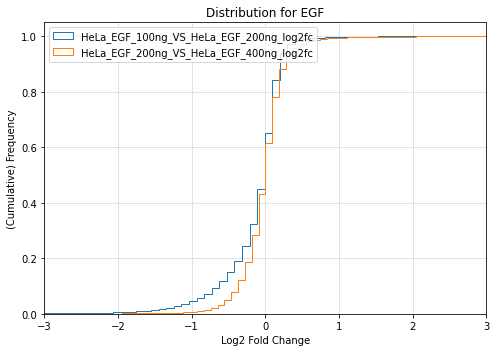

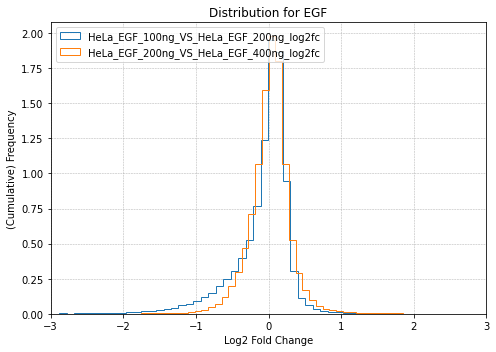

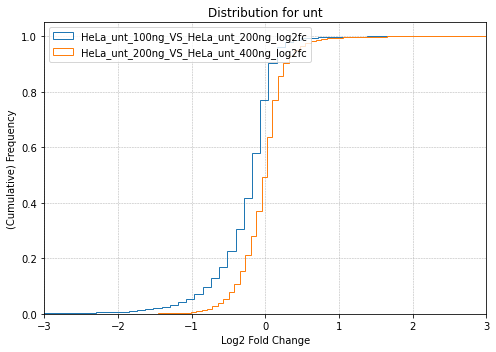

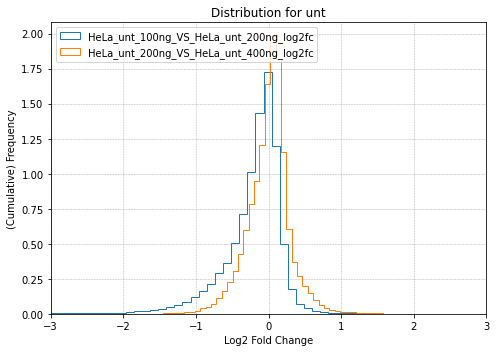

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def cumulative_histogram_for_condition(df, condition, cumulative):
    # Get the log2fc columns for the specified condition
    df = df.dropna()
    log2fc_cols = [col for col in df.columns if condition in col and "log2fc" in col]
    
    if len(log2fc_cols) != 2:
        raise ValueError("There should be exactly 2 log2fc columns for a given condition.")
    
    fig, ax = plt.subplots(figsize=(7, 5))
    
    # Plot cumulative histograms for both columns
    for col in log2fc_cols:
        # Use histtype='step' for better visualization of overlapping histograms
        ax.hist(df[col].dropna(), bins=100, cumulative=cumulative, density=True, histtype='step', label=col)
    
    # Legends, titles and labels
    ax.legend(loc='upper left')
    ax.set_title(f'Distribution for {condition}')
    ax.set_xlabel('Log2 Fold Change')
    ax.set_ylabel('(Cumulative) Frequency')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlim(-3, 3)

    
    plt.tight_layout()
    plt.show()

# Test with a sample DataFrame
# cumulative_histogram_for_condition(df, 'EGF')
cumulative_histogram_for_condition(df_regulation, 'EGF', cumulative=True)
cumulative_histogram_for_condition(df_regulation, 'EGF', cumulative=False)

cumulative_histogram_for_condition(df_regulation, 'unt', cumulative=True)
cumulative_histogram_for_condition(df_regulation, 'unt', cumulative=False)



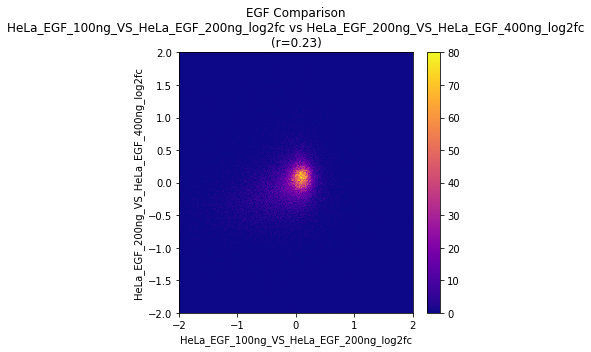

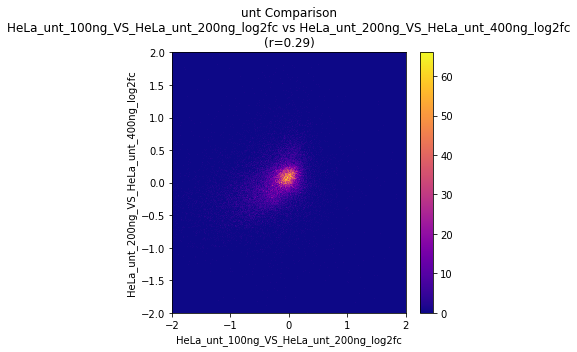

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

def hist2d_for_condition(df, condition):
    # Get the log2fc columns for the specified condition
    log2fc_cols = [col for col in df.columns if condition in col and "log2fc" in col]
    
    if len(log2fc_cols) != 2:
        raise ValueError("There should be exactly 2 log2fc columns for a given condition.")
    
    # Drop rows with NaN values in the columns of interest
    df_clean = df.dropna(subset=log2fc_cols)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # 2D histogram using plt.hist2d
    h = ax.hist2d(df_clean[log2fc_cols[0]], df_clean[log2fc_cols[1]], bins=(1000, 1000), cmap='plasma')
    
    # Add a colorbar to the plot to represent the bin counts
    fig.colorbar(h[3], ax=ax)
    
    # Calculating correlation
    corr = df_clean[log2fc_cols[0]].corr(df_clean[log2fc_cols[1]])
    
    # Setting title with correlation
    ax.set_title(f'{condition} Comparison\n{log2fc_cols[0]} vs {log2fc_cols[1]}\n(r={corr:.2f})')
    ax.set_xlabel(log2fc_cols[0])
    ax.set_ylabel(log2fc_cols[1])
    
    # Ensure the dimensions along both axes are the same
    assert df_clean[log2fc_cols[0]].shape == df_clean[log2fc_cols[1]].shape, "Dimensions along both axes should be the same."

    # Ensure x- and y- limits are the same
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    min_min = min(xlims[0], ylims[0])
    max_max = max(xlims[1], ylims[1])
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# hist2d_for_condition(df, 'EGF')

# Example usage:
# hist2d_for_condition(df, 'EGF')
hist2d_for_condition(df_regulation, 'EGF')
hist2d_for_condition(df_regulation, 'unt')

In [ ]:



results_egf_treated_25_to_100_df = pd.read_csv(results_egf_treated_25_to_100, sep='\t')
results_egf_treated_400_to_100_df = pd.read_csv(results_egf_treated_400_to_100, sep='\t')

#
merged_df = pd.merge(results_egf_treated_25_to_100_df, results_egf_treated_400_to_100_df, on='protein', how='inner', suffixes=('_25_to_100', '_100_to_400'))

merged_df = merged_df[(merged_df["fdr_25_to_100"]<0.01) | (merged_df["fdr_100_to_400"]<0.01)]

display(merged_df)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.scatterplot(data=merged_df, x='log2fc_25_to_100', y='log2fc_100_to_400', ax=ax)
plt.show()

significantly_off_25_to_100 = merged_df[(merged_df["fdr_25_to_100"]<0.01) & (merged_df["log2fc_25_to_100"]>0.7)][""]
significantly_off_100_to_400 = merged_df[(merged_df["fdr_100_to_400"]<0.01) & (merged_df["log2fc_100_to_400"]>0.7)]

venn.venn2()

